# Geração do Banco de Dados 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy.signal import resample

%matplotlib inline

plt.rcParams['xtick.labelsize']  = 18
plt.rcParams['ytick.labelsize']  = 18
plt.rcParams['axes.labelsize']   = 18
plt.rcParams['axes.titlesize']   = 18
plt.rcParams['legend.fontsize']  = 18

In [2]:
def loadh5File(filename):
    """Load h5 database and return signal and time arrays.

    >> loadh5File("input.h5")
    data, time
    """
    h5 = h5py.File(filename,'r')
    print(list(h5.keys()))
    time = np.array(h5['time'])
    data = np.array(h5['data'])
    print(np.shape(data))
    m = np.shape(data)
    m, n = m[0]*m[1], m[2]
    signal = np.zeros([m,n])
    k = 0
    for i in range(len(data)):
        for j in range(len(data[i])):
            signal[k] = data[i][j]
            k += 1
    return signal, time


def removeOffset(data, a, b):
    """Remove signal offset.

    a: número de amostras utilizadas.

    >>> removeOffset(signalArray)
    signalWithoutOffset
    """
    for i in range(len(data)):
        data[i] = data[i] - np.mean(data[i][a:b])
    return data


def fwhm(signal):
    fwhm = np.zeros((signal.shape[0],1))
    for i in range(signal.shape[0]):
        dist = [d for d in range(signal.shape[1]) if signal[i][d] >= max(signal[i])/2]
        fwhm[i] = max(dist) - min(dist)
    return fwhm

## Pré-Processamento

In [3]:
signal_out, time_out = loadh5File("../data/offvalor_11000.0_3.5M.h5")
signal_out = removeOffset(signal_out, 120, 140)
signal_out.shape

['data', 'offvalue', 'time']
(210, 100, 500)


(21000, 500)

In [4]:
# Quantização:  Cada ADC equivale a 9.8 mV.
#               Pedestal médio observado no experimento: 36 ADC.

signal_out = np.round(signal_out/(9.8*10**-3)) - 36
samples    = 50
signal_out = resample(signal_out, samples, axis=1)

isig = np.where(np.max(signal_out,axis=1) < 128)[0]     #Índices de sinais bons    
isat = np.where(np.max(signal_out,axis=1) >= 128)[0]    #Índices de sinais saturados

for i in isat:
    ind = np.where(signal_out[i,:] >= 127)[0]
    signal_out[i,ind] = 127

signal_out = signal_out + 36    #Retirada do pedestal
signal_out = np.roll(signal_out, -6)
signal_out.shape

(21000, 50)

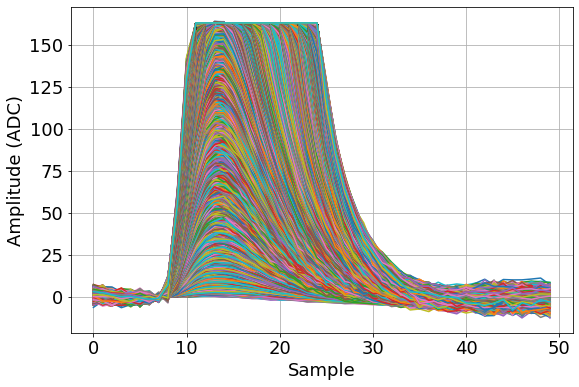

In [5]:
for i in range(len(signal_out)):
    signal_out[i][42:50] = np.std(signal_out[i][38:42])*np.random.randn(8)+signal_out[i,41]
    
plt.figure(figsize=(9,6))    
plt.plot(signal_out.T)
plt.xlabel('Sample')
plt.ylabel('Amplitude (ADC)')
plt.grid()
plt.show()

## Classes de sinais

In [6]:
# Sinais esperados e saturados
sig = signal_out[isig,:]
sat = signal_out[isat,:]
print("Não saturados: ", sig.shape)
print("    Saturados: ", sat.shape)

Não saturados:  (7082, 50)
    Saturados:  (13918, 50)


In [7]:
# Excluindo sinais de baixa energia (Amplitude < 4 ADC)
ind = np.where(np.max(sig, axis=1) >= 4.5)[0]
sig = sig[ind,:]
sig.shape

(5993, 50)

In [8]:
# Sinais cortados
n = 7000
wd = np.random.randint(1100,11000,n)   #Sortear n janelas a partir de 1000
ctd = np.zeros((n, signal_out.shape[1]))
j = 0

# Início da janela
for i in wd[0:int(len(wd)/2)]:
    r   = np.random.randint(8,20)    # Número de índices deslocados
    ctd[j] = np.roll(signal_out[i], -r)
    ind = 50 - r
    ctd[j][ind:50] = np.std(signal_out[i][40:50])*np.random.randn(r)  #Adicionar ruído nas últimas amostras
    j += 1

# Final da janela
for i in wd[int(len(wd)/2):int(len(wd))]:
    r   = np.random.randint(23,41)    # Número de índices deslocados
    ctd[j] = np.roll(signal_out[i], r)
    ind = r - 6
    ctd[j][0:ind] = np.std(signal_out[i][0:5])*np.random.randn(ind)  #Adicionar ruído nas últimas amostras
    j += 1

print("Cortados: ", ctd.shape)

Cortados:  (7000, 50)


In [9]:
# Dois sinais em uma janela
n = 7000
wd = np.random.randint(1100,11000,n)   #Sortear n janelas a partir de 1100
dpc = np.zeros((n, signal_out.shape[1]))
j = 0

for i in wd:
    r = np.random.randint(6,35,1)
    k  = np.random.randint(1000,11000,1)[0]   #Sortear outra janela 
    ind = np.where(signal_out[i][14:50] <= np.roll(signal_out[k],r)[14:50])[0]
    
    while len(ind) == 0:
        k  = np.random.randint(1000,11000,1)[0]   #Sortear outra janela 
        ind = np.where(signal_out[i][14:50] <= np.roll(signal_out[k],r)[14:50])[0]
        
    l = ind[0] + 14
    dpc[j] = signal_out[i]
    dpc[j][l:50] = np.roll(signal_out[k], r)[l:50]
    j +=1

print("Com mais de um pico: ", dpc.shape)

Com mais de um pico:  (7000, 50)


In [10]:
i = np.array(range(10))
sig = np.delete(sig,i,axis=0)
sig.shape

(5983, 50)

In [11]:
# Outliers após cálculo da FWHM
i = [ 68,  71,  80,  84,  89, 142]
sig = np.delete(sig,i,axis=0)
sig.shape

(5977, 50)

In [12]:
# Salvando os bancos de dados em um arquivo .h5
#hf = h5py.File('db_sinais.h5', 'w')   
#hf.create_dataset('esperados', data=sig)
#hf.create_dataset('saturados', data=sat)
#hf.create_dataset('cortados',  data=ctd)
#hf.create_dataset('doisPicos', data=dpc)
#hf.close()

## Extração de parâmetros

- Amplitude
- Área
- Posição da Amplitude
- Largura à meia altura
- Label

In [13]:
#Sinais bons (label 1)
amp_sig  = np.max(sig, axis=1).reshape(-1,1)
area_sig = sum(sig.T).reshape(-1,1)*(0.8)
pAmp_sig = np.argmax(sig,axis=1).reshape(-1,1)
dist_sig = fwhm(sig)
lb_sig   = 1*np.ones((sig.shape[0],1))
db_sig   = np.concatenate((amp_sig, area_sig, pAmp_sig, dist_sig, lb_sig), axis=1)
db_sig.shape

(5977, 5)

In [14]:
#Sinais saturados (label 2)
amp_sat  = np.max(sat, axis=1).reshape(-1,1)
area_sat = sum(sat.T).reshape(-1,1)*(0.8)
pAmp_sat = np.argmax(sat,axis=1).reshape(-1,1)
dist_sat = fwhm(sat)
lb_sat   = 2*np.ones((sat.shape[0],1))
db_sat   = np.concatenate((amp_sat, area_sat, pAmp_sat, dist_sat,lb_sat), axis=1)
db_sat.shape

(13918, 5)

In [15]:
#Sinais cortados (label 3)
amp_ctd  = np.max(ctd, axis=1).reshape(-1,1)
area_ctd = sum(ctd.T).reshape(-1,1)*(0.8)
pAmp_ctd = np.argmax(ctd,axis=1).reshape(-1,1)
dist_ctd = fwhm(ctd)
lb_ctd   = 3*np.ones((ctd.shape[0],1))
db_ctd   = np.concatenate((amp_ctd, area_ctd, pAmp_ctd, dist_ctd, lb_ctd), axis=1)
db_ctd.shape

(7000, 5)

In [16]:
#Sinais com dois picos (label 4)
amp_dpc  = np.max(dpc, axis=1).reshape(-1,1)
area_dpc = sum(dpc.T).reshape(-1,1)*(0.8)
pAmp_dpc = np.argmax(dpc,axis=1).reshape(-1,1)
dist_dpc = fwhm(dpc)
lb_dpc   = 4*np.ones((dpc.shape[0],1))
db_dpc   = np.concatenate((amp_dpc, area_dpc, pAmp_dpc, dist_dpc, lb_dpc), axis=1)
db_dpc.shape

(7000, 5)

In [17]:
#Salvando os bancos de dados de parâmetros em um arquivo .h5
#hf = h5py.File('db_sinais_par.h5', 'w')   
#hf.create_dataset('esperados', data=db_sig)
#hf.create_dataset('saturados', data=db_sat)
#hf.create_dataset('cortados',  data=db_ctd)
#hf.create_dataset('doisPicos', data=db_dpc)
#hf.close()

In [18]:
df = pd.DataFrame(np.concatenate((db_sig, db_sat, db_ctd, db_dpc), axis=0), 
                  columns=['Amp', 'Area', 'Pos_Amp', 'FWHM', 'Label'])
#df.to_csv('DataFrame_Aqst.csv')
df.head()

,Amp,Area,Pos_Amp,FWHM,Label
0,4.524269,115.885600,46.0,38.0,1.0
1,6.026185,85.866508,14.0,34.0,1.0
2,6.023878,56.837471,14.0,8.0,1.0
3,5.075051,-37.638972,13.0,6.0,1.0
4,5.075051,-38.441727,13.0,6.0,1.0
